# bandpass filtering for tidal analysis

In [1]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

## generate synthetic signal

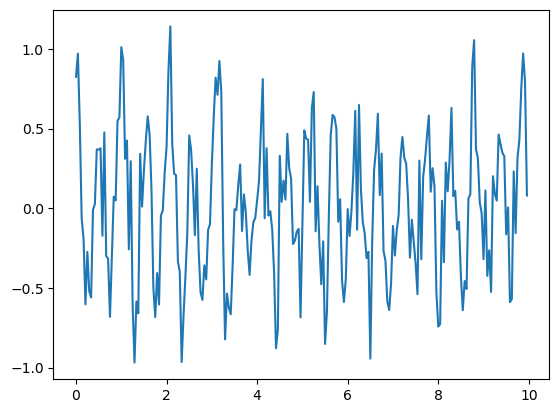

In [2]:

omega= dict(
    M2 = 2*np.pi*24/12.420601,
    S2 = 2*np.pi*24/12,
    K1 = 2*np.pi*24/23.93447213,
    O1 = 2*np.pi*24/25.81933871,
)
a = 2
amplitudes = dict(
    M2 = .24*a,
    S2 = .11,
    K1 = .14,
    O1 = .10,
)


dt = 1/24 # sampling interval in days
t = np.arange(0,30,dt)
y = np.random.randn(t.size)/4
for c in omega:
    y += amplitudes[c] * np.cos(omega[c]*t)

plt.plot(t[:24*10],y[:24*10])

## generate filter

In [3]:
# utils
def generate_filter(
    band,
    T=10,
    dt=1 / 24,
    lat=None,
    bandwidth=None,
    normalized_bandwidth=None,
):
    """Wrapper around scipy.signal.firwing

    Parameters
    ----------
    band: str, float
        Frequency band (e.g. "semidiurnal", ...) or filter central frequency in cpd
    T: float
        Filter length in days
    dt: float
        Filter/time series time step
    lat: float
        Latitude (for inertial band)
    bandwidth: float
        Filter bandwidth in cpd
    dt: float
        days
    """
    numtaps = int(T / dt)
    pass_zero = False
    #
    if band == "low":
        pass_zero = True
        cutoff = [bandwidth]
    elif band == "subdiurnal":
        pass_zero = True
        cutoff = [1.0 / 2.0]
    elif band == "semidiurnal":
        omega = 1.9322  #  M2 24/12.4206012 = 1.9322
    elif band == "diurnal":
        omega = 1.0  # K1 24/23.93447213 = 1.0027
    elif isinstance(band, float):
        omega = band
    #
    if bandwidth is not None and band != "low":
        cutoff = [omega - bandwidth, omega + bandwidth]
    elif normalized_bandwidth is not None:
        cutoff = [
            omega * (1 - normalized_bandwidth),
            omega * (1.0 + normalized_bandwidth),
        ]
    #
    h = signal.firwin(
        numtaps, cutoff=cutoff, pass_zero=pass_zero, fs=1 / dt, scale=True
    )
    return h

In [4]:
b = .3 # cycles per days
T = 5 # kernel length in days

kwargs = dict(T=T, dt=dt, bandwidth=b)
h2 = generate_filter("semidiurnal", **kwargs)
h1 = generate_filter("diurnal", **kwargs)

w2, hh2 = signal.freqz(h2, worN=8000, fs=1/dt)
w1, hh1 = signal.freqz(h1, worN=8000, fs=1/dt)

Text(0.5, 1.0, 'filter frequency response')

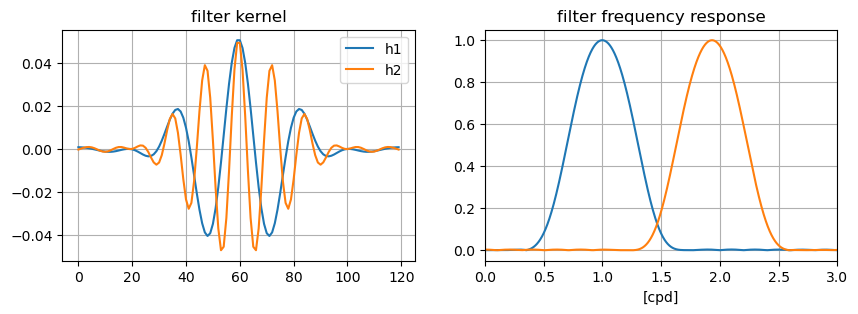

In [5]:
# inspect kernels

fig, axes = plt.subplots(1, 2, figsize=(10, 3))

ax = axes[0]
ax.plot(h1, label="h1")
ax.plot(h2, label="h2")
ax.grid()
ax.legend()
ax.set_title("filter kernel")

ax = axes[1]
ax.plot(w1, np.abs(hh1))
ax.plot(w2, np.abs(hh2))
# ax.set_yscale("log")
# ax.set_xscale("log")
ax.set_xlim(0, 3)
ax.grid()
ax.set_xlabel("[cpd]")
ax.set_title("filter frequency response")

## apply filter and compare

In [6]:
y1 = signal.filtfilt(h1, [1], y)
y2 = signal.filtfilt(h2, [1], y)

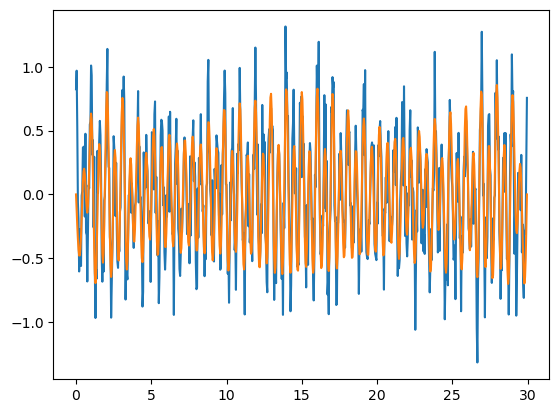

In [8]:
fig, ax = plt.subplots(1,1)
ax.plot(t, y)
ax.plot(t, y1+y2)

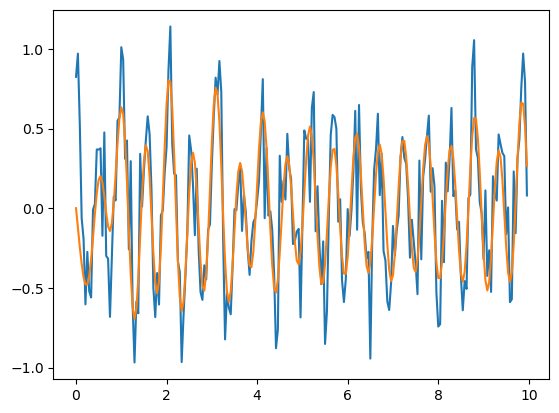

In [9]:
i = 24*10
fig, ax = plt.subplots(1,1)
ax.plot(t[:i], y[:i])
ax.plot(t[:i], (y1+y2)[:i])

Now we can ready to make an harmonic analysis on the filtered signal y1+y2

---

## harmonic analysis of a referenced (differentiated) signal

Assume the tidal signal along the cable is written as:

$
\begin{align}
y(c, t) = \Re \Big \{\sum_i A_i(c) e^{i(\omega_i t + \phi_i(c))} \Big \},
\end{align}
$

where $c$ and $t$ are the channel and time coordinates respectively, 
where $A_i(c)$ and $\phi_i(c)$ are the amplitude and phase of the tidal signal at channel $c$.

Assume now you are measuring the difference of the signal at channel $c$ with that at channel $c_0$:

$
\begin{align}
\delta y(c,t) = y(c, t) - y(c_0,t) &= \Re \Big \{\sum_i \big [ A_i(c) e^{i\phi_i(c)} - A_i(c_0) e^{i\phi_i(c_0)} \big ] e^{i\omega_i t} \Big \}, \\
&= \Re \Big \{\sum_i A_i^\delta(c) e^{i(\omega_i t + \phi_i^\delta(c))} \Big \},
\end{align}
$

So the complex amplitude of the difference is the difference of complex amplitudes.
The absolute amplitude of the difference $A_i^\delta(c)$ is not directly related to the difference of amplitudes ($A_i(c) - A_i(c_0)$) but instead:

$
\begin{align}
A_i^\delta(c) = \big | A_i(c) e^{i\phi_i(c)} - A_i(c_0) e^{i\phi_i(c_0)} \big |.
\end{align}
$

Don't forget to convert phases in radians !
